cnn-trash-classifier

In [1]:
pip install tensorflow numpy pandas matplotlib scikit-learn huggingface-hub datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Load dataset from https://huggingface.co/datasets/garythung/trashnet

In [1]:
from datasets import load_dataset

dataset = load_dataset("garythung/trashnet")

C:\Users\jdarm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Function to prepare the data for training by organizing it into directories

In [8]:
def prepare_data(dataset):
    base_path = "./trashnet_data"
    os.makedirs(base_path, exist_ok=True)

    for split in dataset.keys():
        split_path = os.path.join(base_path, split)
        os.makedirs(split_path, exist_ok=True)

        for i, data in enumerate(dataset[split]):
            label = data['label']
            image = data['image']
            label_path = os.path.join(split_path, str(label))
            os.makedirs(label_path, exist_ok=True)
            
            image.save(os.path.join(label_path, f"{i}.jpg"))

prepare_data(dataset)

Data augmentation and preprocessing for training and validation and create training data & validation data generator

In [37]:
image_size = 128
batch_size = 32
epoch = 20
lr =  0.001

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=0.2 
)

train_generator = train_datagen.flow_from_directory(
    './trashnet_data/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    './trashnet_data/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# for i in range(5):
#     images, labels = next(train_generator)
#     plt.subplot(1, 5, i+1)
#     plt.imshow(images[0])
#     plt.axis('off')
# plt.show()


Found 4046 images belonging to 6 classes.
Found 1008 images belonging to 6 classes.


Define the CNN model architecture (layer)

In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax') 
])


Compile the model with Nadam optimizer and categorical crossentropy loss

In [39]:
model.compile(
    optimizer=Nadam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Train the model

In [40]:
history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=val_generator
)

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 839ms/step - accuracy: 0.2746 - loss: 1.6797 - val_accuracy: 0.4008 - val_loss: 1.3958
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 104s 823ms/step - accuracy: 0.4127 - loss: 1.4088 - val_accuracy: 0.4702 - val_loss: 1.3577
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 105s 825ms/step - accuracy: 0.4857 - loss: 1.2974 - val_accuracy: 0.5337 - val_loss: 1.1561
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 105s 828ms/step - accuracy: 0.5522 - loss: 1.1808 - val_accuracy: 0.5694 - val_loss: 1.1154
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 105s 825ms/step - accuracy: 0.5767 - loss: 1.1394 - val_accuracy: 0.6121 - val_loss: 1.0382
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 105s 826ms/step - accuracy: 0.5969 - loss: 1.0698 - val_accuracy: 0.6161 - val_loss: 1.0213
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 104s 824ms/step - accuracy: 0.6397 - loss: 0.9886 - val_accuracy: 0.6448 - val_loss: 0.9739
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 104s 821ms/step - accuracy: 0.6598 -

Evaluate the model on the validation data

In [41]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 934ms/step - accuracy: 0.7998 - loss: 0.5822
Validation Accuracy: 0.80


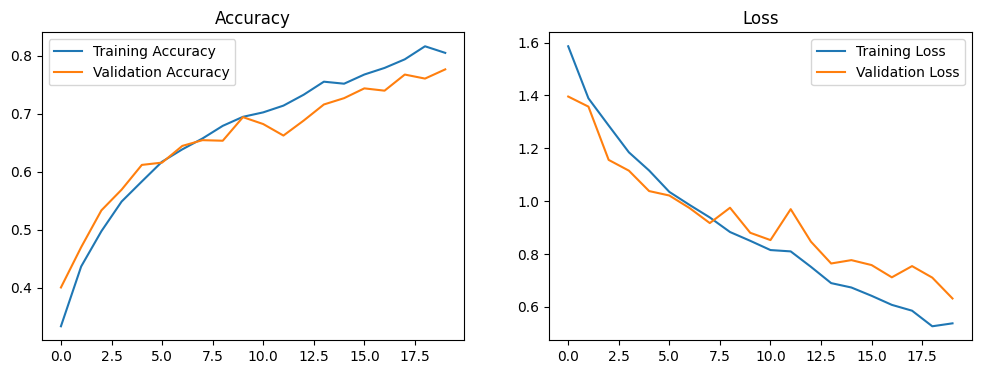

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(image_path, model, class_indices):
    image = load_img(image_path, target_size=(image_size, image_size))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    class_name = list(class_indices.keys())[np.argmax(prediction)]
    match class_name:
        case '0':
            return 'cardboard'
        case '1':
            return 'glass'
        case '2':
            return 'metal'
        case '3':
            return 'paper'
        case '4':
            return 'plastic'
        case '5':
            return 'trash'

class_indices = train_generator.class_indices
print(predict_image('./trashnet_data/test/0/cardboard.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/1/glass.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/2/metal.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/3/paper.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/4/plastic.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/5/trash2.jpg', model, class_indices))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
glass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
plastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
trash


In [49]:
model.export("model/cnn_trash_classifier")

INFO:tensorflow:Assets written to: model/cnn_trash_classifier\assets


INFO:tensorflow:Assets written to: model/cnn_trash_classifier\assets


Saved artifact at 'model/cnn_trash_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1398280055376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398280050576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285116496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285116112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285118416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285118224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285119184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285114000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285117264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285117072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398285120336: Tensor

In [50]:
model.save("model/cnn_trash_classifier.keras")

In [51]:
pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.0 MB 4.2 MB/s eta 0:00:03
   ----- ---------------------------------- 1.3/10.0 MB 4.8 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/10.0 MB 4.8 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/10.0 MB 5.0 MB/s eta 0:00:02
   ------------------ --------------------- 4.7/10.0 MB 5.2 MB/s eta 0:00:02
   ------------------------- -------------- 6.3/10.0 MB 5.6 MB/s eta 0:00:01
   -------------------------------- ------- 8.1/10.0 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------  10.0/10.0 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 6.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------- ----------------- 1.3/2.4 MB 8.4 MB/s eta 0:00:01
   ---------

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('model/cnn_trash_classifier.keras')

In [2]:
from huggingface_hub import login

login(token="")


C:\Users\jdarm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from huggingface_hub import create_repo, upload_folder

model_name = "cnn_trash_classifier"
model_path = "./model" 

create_repo(model_name, exist_ok=True)

upload_folder(
    folder_path=model_path,
    repo_id=f"jdarmawan-jd/{model_name}",
    commit_message="Initial model upload"
)

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]





fingerprint.pb: 100%|██████████| 57.0/57.0 [00:00<00:00, 255B/s]











fingerprint.pb: 100%|██████████| 57.0/57.0 [00:00<00:00, 105B/s]









saved_model.pb: 100%|██████████| 86.4k/86.4k [00:00<00:00, 103kB/s] 







































































































variables.data-00000-of-00001: 100%|██████████| 12.6M/12.6M [00:05<00:00, 2.37MB/s]








































































































cnn_trash_classifier.keras: 100%|██████████| 18.9M/18.9M [00:09<00:00, 1.94MB/s]


Upload 4 LFS files: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


CommitInfo(commit_url='https://huggingface.co/jdarmawan-jd/cnn_trash_classifier/commit/fc5359e363befb5de4d54190cf4a4cf20e109cc7', commit_message='Initial model upload', commit_description='', oid='fc5359e363befb5de4d54190cf4a4cf20e109cc7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jdarmawan-jd/cnn_trash_classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='jdarmawan-jd/cnn_trash_classifier'), pr_revision=None, pr_num=None)